# Basic GP Classification model


This script shows how to build a GP classification model using variational inference. We first look at a one-dimensional example, and then show how this can be adapted when the input space is 2D.

In [1]:
import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (8, 4)

## 1D example

First of all, let's have a look at the data:

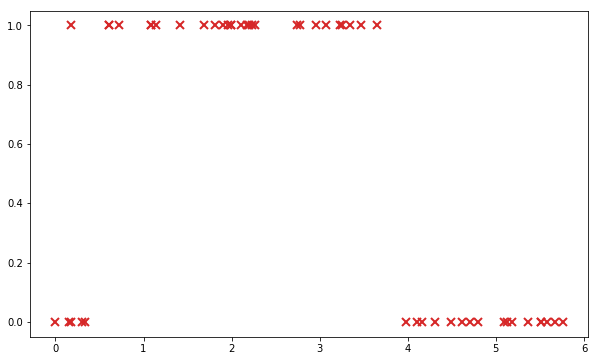

In [2]:
X = np.genfromtxt('data/classif_1D_X.csv').reshape(-1, 1)
Y = np.genfromtxt('data/classif_1D_Y.csv').reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.plot(X, Y, 'C3x', ms=8, mew=2);

### Reminders on the GP classification

The simplest GP classification model consists in using a `Bernouilli` likelihood. The details of the generative model are as follow:

__1. Define the latent GP:__ we start from a gaussian process $f \sim \mathcal{N}(0, k)$:

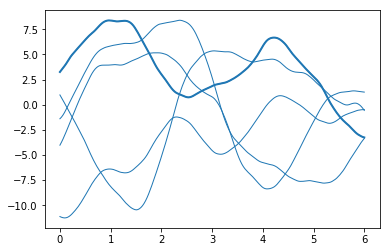

In [3]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(1, variance=20.)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k.compute_K_symm(x_grid)

# sample from a multivariate normal
L = np.linalg.cholesky(K)
f_grid = np.dot(L, np.random.RandomState(6).randn(200, 5))
plt.plot(x_grid, f_grid, 'C0', linewidth=1)
plt.plot(x_grid, f_grid[:, 1], 'C0', linewidth=2);

__2. Squash them to $[0, 1]$:__ the samples of the GP are mapped to $[0, 1]$ using the logistic inverse link function: $g(x) = \frac{\exp(f(x))}{1 + \exp(f(x))}$.

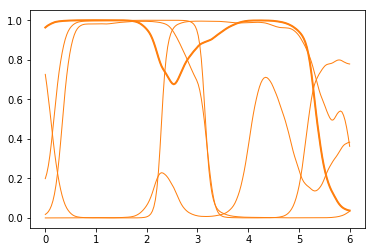

In [4]:
p_grid = np.exp(f_grid) / (1 + np.exp(f_grid))
plt.plot(x_grid, p_grid, 'C1', linewidth=1)
plt.plot(x_grid, p_grid[:, 1], 'C1', linewidth=2);

__3. Sample from a Bernouilli:__ for each observation point $X_i$, the class label $Y_i \in \{0, 1\}$ is generated by sampling from a Bernouilli distribution $Y_i \sim \mathcal{B}(g(X_i))$.

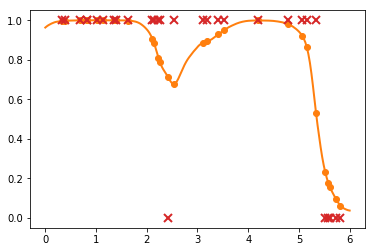

In [5]:
# Select some input locations
ind = np.random.randint(0, 200, (30,))
X_gen = x_grid[ind]

# evaluate probability and get bernoulli draws
p = p_grid[ind, 1:2]
Y_gen = np.random.binomial(1, p)

#plot
plt.plot(x_grid, p_grid[:, 1], 'C1', linewidth=2)
plt.plot(X_gen, p, 'C1o', ms=6)
plt.plot(X_gen, Y_gen, 'C3x', ms=8, mew=2);

### Implementation with GPflow

For the model described above, the posterior $f(x)|Y$ (say $p$) is not gaussian anymore and does not have a closed form expression. A common approach is then to look for the best approximation of this posterior by a tractable distribution (say $q$) such as a Gaussian distribution. In variational inference, the quality of an approximation is measured by the KL divergence between $KL[q || p]$. For more details on this model, see Nickisch et al (2008).

The inference problem is thus turned into an optimisation problem: finding the best parametres for $q$. In our case, we introduce $U \sim \mathcal{N}(q_\mu, q_\Sigma)$ we choose $q$ to have the same distribution as $f | f(X) = U$. The parameters $q_\mu$ and $q_\Sigma$ can be seen as parametres of $q$, which can be optimised in order to minimise  $KL[q || p]$. 

This variational inference model is called `VGP` in GPflow:

In [6]:
m = gpflow.models.VGP(X, Y,
                      likelihood=gpflow.likelihoods.Bernoulli(),
                      kern=gpflow.kernels.Matern52(1))

o = gpflow.train.ScipyOptimizer()
o.minimize(m);

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 11.678611
  Number of iterations: 150
  Number of functions evaluations: 157


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 11.678611
  Number of iterations: 150
  Number of functions evaluations: 157


We can now inspect the result of the optimisation with `print(m)` or `m.as_pandas_table()`:

In [7]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,1.6355003192882445
VGP/kern/variance,Parameter,None,+ve,True,(),True,32.92700076548122
VGP/q_mu,Parameter,None,(none),True,"(50, 1)",True,"[[-1.1196742258326438], [0.2620987093978069], ..."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 50, 50)",True,"[[[0.45544562836404157, 0.0, 0.0, 0.0, 0.0, 0...."


In this table, the first two lines are associated to the kernel parametres, and the last two correspond to the variational parameters. Note that in practice, $q_\Sigma$ is actually parametrised by its lower-triangular square root $q_\Sigma = q_{sqrt} q_{sqrt}^T$ in oder to ensure it's positive definiteness.

For more details on how to handle models in GPflow (getting/setting parameters, fixing some of them during optim, using priors...), we refer the reader to the [notebook on models](../understanding/models.ipynb).

### Predictions

Finally, we will see how to use model predictions to plot the resulting model. We will replicate the figures of the generative model above, but using the approximate posterior distribution given by the model.

(-3, 3)

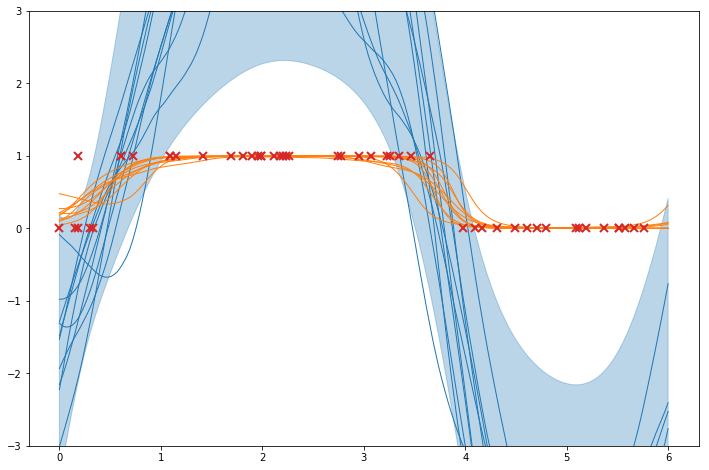

In [8]:
plt.figure(figsize=(12, 8))

# bubble fill the predictions
mu, var = m.predict_f(x_grid)
plt.fill_between(x_grid.flatten(),
                 (mu + 2 * np.sqrt(var)).flatten(),
                 (mu - 2 * np.sqrt(var)).flatten(),
                 alpha=0.3, color='C0')
    
# plot samples
samples = m.predict_f_samples(x_grid, 10).squeeze().T
plt.plot(x_grid, samples, 'C0', lw=1)
    
# plot p-samples
p = np.exp(samples) / (1. + np.exp(samples))
plt.plot(x_grid, p, 'C1', lw=1)

# plot data
plt.plot(X, Y, 'C3x', ms=8, mew=2)
plt.ylim((-3,3))

## 2D example

In this section we will use the following data:

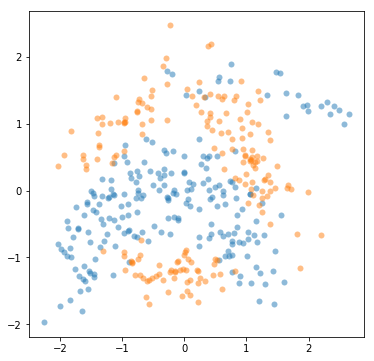

In [9]:
X = np.loadtxt('data/banana_X_train', delimiter=',')
Y = np.loadtxt('data/banana_Y_train', delimiter=',').reshape(-1,1)
mask = Y[:, 0]==1

plt.figure(figsize=(6, 6))
plt.plot(X[mask, 0], X[mask, 1], 'oC0', mew=0, alpha=0.5)
plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], 'oC1', mew=0, alpha=0.5);


The model definition is the same as above, the only important difference is that we now specify that the kernel operates over a 2D input space:

In [10]:
m = gpflow.models.VGP(X, Y,
                      kern=gpflow.kernels.RBF(2),
                      likelihood=gpflow.likelihoods.Bernoulli())

opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=50) # in practice, the optimisation needs around 250 iterations to converge


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 107.177391
  Number of iterations: 50
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 107.177391
  Number of iterations: 50
  Number of functions evaluations: 52


We can now plot the predicted decision boundary between the two classes. To do so, we can equivalently plot the contourlines $E[f(x)|Y]=0$, or $E[g(f(x))|Y]=.5$. We will do the later since it allows us to discover a the function `predict_y`:

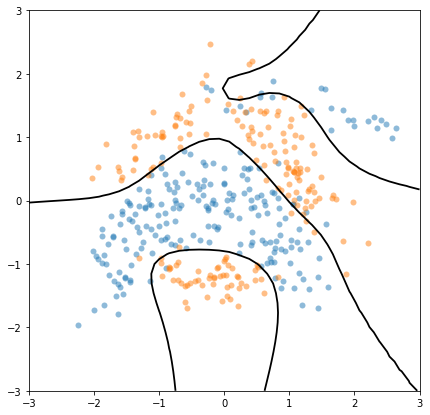

In [11]:
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(),yy.flatten())).T

p = m.predict_y(Xplot)[0]
plt.figure(figsize=(7, 7))
plt.plot(X[mask, 0], X[mask, 1], 'oC0', mew=0, alpha=0.5)
plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], 'oC1', mew=0, alpha=0.5);

plt.contour(xx, yy, p.reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100);

# Further reading

There are dedicated notebooks giving more details on how to manipulate [models](../understanding/models.ipynb) and [kernels](../advanced/kernels.ipynb).

This notebook only covers very basic classification models. You may also be interested in:
  * [Sparse models](many_points.ipynb). The models above have one inducing variable $U_i$ per observation point $X_i$, which does not scale to large datasets. SVGP (Sparse Variational GP) is an efficient alternative where the variables $U_i$ are defined at some inducing input locations $Z_i$ that can also be optimized.
  * [Exact inference](../advanced/MCMC.ipynb). We have seen that variational inference provides an approximation to the posterior. GPflow also supports exact inference using MCMC methods, and the kernel parameters can also be assigned prior distribution in order to avoid point estimates.
  
# References

[1] Nickisch, Hannes, and Carl Edward Rasmussen. "Approximations for binary Gaussian process classification." Journal of Machine Learning Research 9.Oct (2008): 2035-2078.